In [ ]:
import os
import pickle
import random
import torch
from models.gait_fc import GaitFC, GaitFCV2
import numpy as np


In [ ]:
root = 'gait_fc_dataset/test_p2'
ids = os.listdir(root)
print(len(ids))

videos_db = []
target_db = []

video_at = []
target_at = []

for idx in ids:

    # print(idx)
    videos = os.listdir(os.path.join(root, idx))
    videos = [os.path.join(root, idx, v) for v in videos]

    scale = int(len(videos)/2)

    video_at += videos[:scale]
    target_at += [int(idx)] * len(videos[:scale])

    videos_db += videos[scale:]
    target_db += [int(idx)] * len(videos[scale:])

# print(set(idd).__len__())

print(len(videos_db), len(video_at))
print(len(target_db), len(target_at))

print(len(set(target_db)))
print(len(set(target_at)))

In [ ]:
def calc_euclidean(feat1, feat2):
    feat1 = feat1.ravel()
    feat2 = feat2.ravel()
    return torch.dot(feat1, feat2) / (torch.linalg.norm(feat1) * torch.linalg.norm(feat2))

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

device = torch.device('cpu')
model = GaitFCV2()
model.load_state_dict(torch.load('src/gait_fcv2_epoch_27.pt'))

# model = GaitFCV2()
# model.load_state_dict(torch.load('src/gait_fcv2_epoch_50.pt'))
model.to(device)
model.eval()

In [ ]:
def preprocess(vid):
    with open(vid, 'rb') as handle:
        anchor_vid = pickle.load(handle)
        a_v = anchor_vid['ae_feat']
        a_v = softmax(a_v)
        a_gei = anchor_vid['gei']
        a_gei = np.expand_dims(a_gei, axis=0)/40
    a_v = torch.from_numpy(a_v).float()
    a_gei = torch.from_numpy(a_gei).float()
    return a_v, a_gei

a_v, a_gei = preprocess('gait_fc_dataset/test/0/000.pkl')
feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
print(feat)

# Get embedding for db

In [6]:
embeddings_db = []
target_embed_db = []
with torch.no_grad():
    for idx, vid in zip(target_db, videos_db):
        a_v, a_gei = preprocess(vid)
        # print(a_v.shape)
        # print(a_gei.shape)
        feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
        embeddings_db.append(feat[0])
        target_embed_db.append(idx)
        # break

print(len(embeddings_db))


1990


# Attack

In [10]:
truth = []
pred = []

d_means = []
for name, vid in zip(target_at, video_at):
    a_v, a_gei = preprocess(vid)
    with torch.no_grad():
        feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
    max_d = -1
    predict_name = -1
    for t, a in zip(target_embed_db, embeddings_db):
        d = calc_euclidean(feat, a)
        if d > max_d:
            max_d = d
            predict_name = t
        # print(d.item())
    d_means.append(max_d)
    truth.append(name)
    pred.append(predict_name)
    # break
print(sum(d_means)/len(d_means))


C:\Users\Cuong Tran\AppData\Roaming\Python\Python38\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


tensor(0.6599)


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(truth, pred)
acc = accuracy_score(truth, pred)
print(cm)
print(acc)

[[ 5  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 58  0]
 [ 0  0  0 ...  0  0 55]]
0.9443025038323966


In [7]:
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


def plot_cm(CM, normalize=True, save_dir='', names=(), show=True, title=''):
    if True:
        import seaborn as sn
        array = CM/((CM.sum(0).reshape(1, -1) + 1E-6) if normalize else 1)  # normalize columns
        if not normalize:
            array = np.asarray(array, dtype='int')
        fmt = 'd'
        if normalize:
            fmt = '.2f'
            array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)
        fig = plt.figure(figsize=(12, 9), tight_layout=True)
        sn.set(font_scale=1.0 if 2 < 50 else 0.8)  # for label size
        labels = (0 < len(names) < 99) and len(names) == 2  # apply names to ticklabels
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
            sn.heatmap(array, annot=2 < 30, annot_kws={"size": 8}, cmap='Blues', fmt=fmt, square=True,
                       xticklabels=names if labels else "auto",
                       yticklabels=names if labels else "auto").set_facecolor((1, 1, 1))
        fig.axes[0].set_xlabel('True')
        fig.axes[0].set_ylabel('Predicted')
        fig.axes[0].set_title(title)
        if show:
            plt.show()
        name_save = 'confusion_matrix.png'
        if normalize:
            name_save = 'confusion_matrix_normalize.png'
        fig.savefig(Path(save_dir) / name_save, dpi=250)
        plt.close()



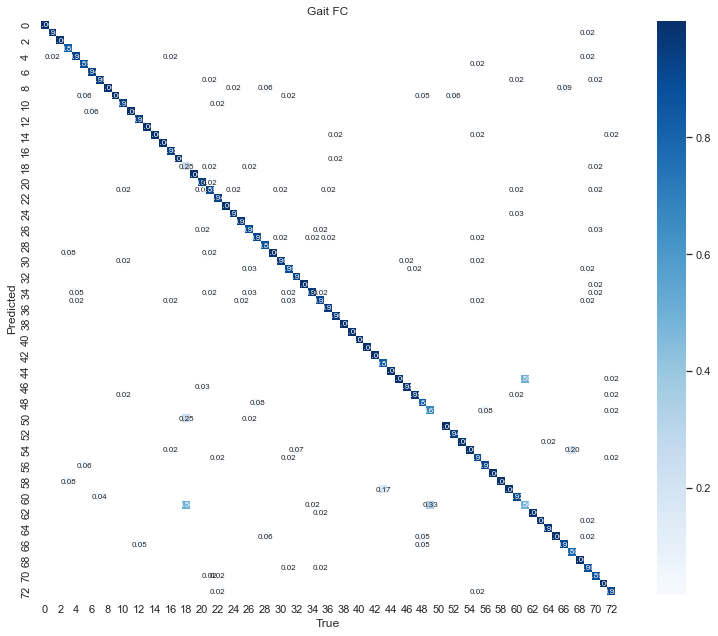

In [12]:
plot_cm(cm, title='Gait FC')

# Attach v2: with thresshold

In [23]:
truth = []
pred = []

thress = 0.3

false_over_thress = 0

d_means = []
for name, vid in zip(target_at, video_at):
    a_v, a_gei = preprocess(vid)
    feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))

    predict_name = 73
    max_d = -1
    for t, a in zip(target_embed_db, embeddings_db):
        d = calc_euclidean(feat, a)
        if d > thress:
            if t != name:
                false_over_thress += 1
            if d> max_d:
                predict_name = t
                max_d = d

    # print(predict_name, name)
    truth.append(name)
    pred.append(predict_name)
print(false_over_thress)
#     # break/

C:\Users\Cuong Tran\AppData\Roaming\Python\Python38\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


41704


7
[[ 5  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ... 58  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0  0]]
0.943791517629024


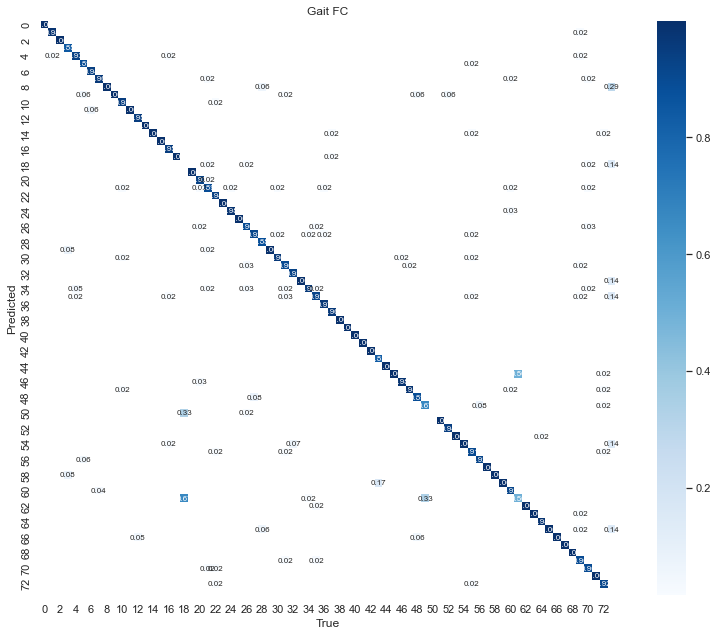

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(truth, pred)
acc = accuracy_score(truth, pred)
print(pred.count(73))
print(cm)
print(acc)
plot_cm(cm, title='Gait FC')

# Attach v3: SVM

In [ ]:
from sklearn import svm

SVM = svm.SVC()
X = np.array([e.cpu().numpy() for e in embeddings_db])
y = np.array(target_db)
print(set(y.tolist()).__len__())
# print(X.shape, y.shape)
SVM.fit(X, y)



In [ ]:
truth = []
pred = []

d_means = []


for name, vid in zip(target_at, video_at):
    a_v, a_gei = preprocess(vid)
    with torch.no_grad():
        feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
    feat = feat.cpu().numpy()
    pred_name = SVM.predict(feat)[0]
    truth.append(name)
    pred.append(pred_name)

print(pred, truth)
    # break

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(truth, pred)
acc = accuracy_score(truth, pred)
print(cm)
print(acc)
plot_cm(cm, title='Gait FC')
